In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Parameters

In [2]:
# params
DATE_RANGE = '2000_to_2020'

DATA_PATH = f'input/imputed/df_wide_knn_imputed_{DATE_RANGE}.csv'
FEATURE_IMPORTANCE_PATH = f'output/feature_importance/xgb_tuned_feature_importances_multi_target_{DATE_RANGE}.csv'

# PCA params
N_FEATURES = 10
N_COMPONENTS = 2

# DBSCAN params
EPSILON = 0.2
MIN_SAMPLES = 3

# Pull Data and Standardize

In [3]:
# get data
top_features = pd.read_csv(FEATURE_IMPORTANCE_PATH).head(N_FEATURES)['Feature'].tolist()
print(top_features)

data = pd.read_csv(DATA_PATH, usecols=['Country Name', 'Country Code', 'Year'] + top_features)
display(data)
data_features = data[top_features]
data_labels = data[['Country Name', 'Country Code', 'Year']]

['SH.DYN.AIDS.FE.ZS', 'SL.IND.EMPL.FE.ZS', 'SH.DYN.AIDS.ZS', 'EN.GHG.CO2.LU.DF.MT.CE.AR5', 'TX.VAL.AGRI.ZS.UN', 'AG.LND.AGRI.ZS', 'IC.WRH.DURS', 'NV.IND.MANF.ZS', 'SH.TBS.DTEC.ZS', 'EN.GHG.CO2.LU.MT.CE.AR5']


,Country Name,Country Code,Year,AG.LND.AGRI.ZS,EN.GHG.CO2.LU.DF.MT.CE.AR5,EN.GHG.CO2.LU.MT.CE.AR5,IC.WRH.DURS,NV.IND.MANF.ZS,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.TBS.DTEC.ZS,SL.IND.EMPL.FE.ZS,TX.VAL.AGRI.ZS.UN
0,Afghanistan,AFG,2000-12-31,57.945817,8.8889,9.4311,122.339408,14.763489,27.461007,0.1,19.0,9.125426,3.720211
1,Afghanistan,AFG,2001-12-31,57.947350,8.8889,9.4311,122.350774,16.168582,27.503461,0.1,26.0,9.300166,3.680010
2,Afghanistan,AFG,2002-12-31,57.939684,8.8889,9.4311,358.000000,18.822752,27.547014,0.1,34.0,9.706166,8.397860
3,Afghanistan,AFG,2003-12-31,58.083805,8.8889,9.4311,358.000000,16.923866,27.616006,0.1,32.0,9.742447,12.668359
4,Afghanistan,AFG,2004-12-31,58.151266,8.8889,9.4311,358.000000,17.554006,27.748782,0.1,41.0,10.003830,12.583658
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3839,Zimbabwe,ZWE,2014-12-31,40.012908,27.7500,16.2710,448.000000,12.590765,59.606951,14.7,75.0,2.215261,3.751916
3840,Zimbabwe,ZWE,2015-12-31,39.917986,27.7500,16.2710,448.000000,11.888599,59.740456,14.4,78.0,2.515801,3.501931
3841,Zimbabwe,ZWE,2016-12-31,40.138999,27.7500,16.2710,238.000000,11.596020,59.888983,14.0,78.0,2.884831,2.880592
3842,Zimbabwe,ZWE,2018-12-31,39.983535,27.7500,16.2710,208.000000,13.678137,60.216147,13.1,80.0,3.844617,3.223298


In [4]:
# Drop NAs if applicable
print(f"Shape of data: {data_features.shape}")
print(f"NAs: {data_features.isna().sum().sum():,}")

# drop NAs
data_features = data_features.dropna()

print(f"\nShape of data after dropping NAs: {data_features.shape}")
print(f"NAs: {data_features.isna().sum().sum():,}")

Shape of data: (3844, 10)
NAs: 0

Shape of data after dropping NAs: (3844, 10)
NAs: 0


In [5]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_features)
print(f"\nShape of scaled data: {data_scaled.shape}")


Shape of scaled data: (3844, 10)


# PCA

In [6]:
# Perform PCA with dynamic number of components
pca = PCA(n_components=N_COMPONENTS)
data_pca = pca.fit_transform(data_scaled)

# Create column names for principal components
pca_columns = [f'PC{i+1}' for i in range(N_COMPONENTS)]
data_pca_df = pd.DataFrame(data_pca, columns=pca_columns)

# Combine with labels
data_pca_df = pd.concat([data_labels, data_pca_df], axis=1)
display(data_pca_df)

,Country Name,Country Code,Year,PC1,PC2
0,Afghanistan,AFG,2000-12-31,0.901788,0.329409
1,Afghanistan,AFG,2001-12-31,0.723303,0.428787
2,Afghanistan,AFG,2002-12-31,1.240819,0.957353
3,Afghanistan,AFG,2003-12-31,1.413959,0.744467
4,Afghanistan,AFG,2004-12-31,1.176505,0.789926
...,...,...,...,...,...
3839,Zimbabwe,ZWE,2014-12-31,2.685853,-0.710280
3840,Zimbabwe,ZWE,2015-12-31,2.559014,-0.738935
3841,Zimbabwe,ZWE,2016-12-31,1.992404,-1.080713
3842,Zimbabwe,ZWE,2018-12-31,1.797265,-0.908402


,Principal Component,Explained Variance Ratio (%),Cumulative Explained Variance (%)
0,PC1,22.603956,22.603956
1,PC2,16.888020,39.491977


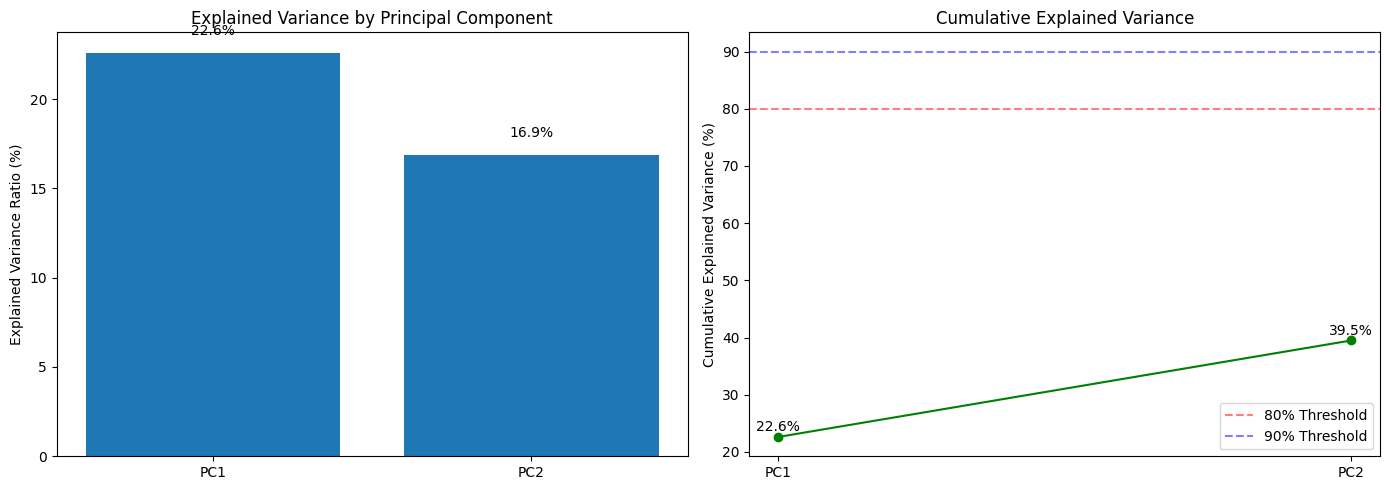

In [7]:
# Ensure output directory exists
os.makedirs('output/pca', exist_ok=True)

# Calculate PCA evaluation metrics
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Create a dataframe to display the metrics
pc_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(N_COMPONENTS)],
    'Explained Variance Ratio (%)': explained_variance * 100,
    'Cumulative Explained Variance (%)': cumulative_variance * 100
})

# Display the metrics as a table
display(pc_df)

# Create a bar chart to visualize explained variance
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for individual explained variance
ax[0].bar(pca_columns, explained_variance * 100)
ax[0].set_ylabel('Explained Variance Ratio (%)')
ax[0].set_title('Explained Variance by Principal Component')
for i, v in enumerate(explained_variance):
    ax[0].text(i, v*100 + 1, f'{v*100:.1f}%', ha='center')

# Line plot for cumulative explained variance
ax[1].plot(pca_columns, cumulative_variance * 100, 'o-', color='green')
ax[1].set_ylabel('Cumulative Explained Variance (%)')
ax[1].set_title('Cumulative Explained Variance')
for i, v in enumerate(cumulative_variance):
    ax[1].text(i, v*100 + 1, f'{v*100:.1f}%', ha='center')
ax[1].axhline(y=80, color='r', linestyle='--', alpha=0.5, label='80% Threshold')
ax[1].axhline(y=90, color='b', linestyle='--', alpha=0.5, label='90% Threshold')
ax[1].legend()

plt.tight_layout()
plt.savefig(f'output/pca/pca{N_COMPONENTS}_explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()

# Clustering

In [8]:
# Clustering
dbscan = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES)

for year in data_labels['Year'].unique():
    dbscan.fit(data_pca_df[data_pca_df['Year'] == year][pca_columns])
    data_pca_df.loc[data_pca_df['Year'] == year, 'Cluster'] = dbscan.labels_
    silhouette_avg = silhouette_score(data_pca_df[data_pca_df['Year'] == year][pca_columns], dbscan.labels_)
    print(f"Year: {year}, Silhouette Score: {silhouette_avg:.2f}")

# Save the clustered data
data_pca_df.to_csv(f'output/pca/clustered_data_{DATE_RANGE}.csv', index=False)
display(data_pca_df)

Year: 2000-12-31, Silhouette Score: 0.02
Year: 2001-12-31, Silhouette Score: -0.06
Year: 2002-12-31, Silhouette Score: -0.04
Year: 2003-12-31, Silhouette Score: -0.14
Year: 2004-12-31, Silhouette Score: -0.14
Year: 2005-12-31, Silhouette Score: -0.17
Year: 2006-12-31, Silhouette Score: -0.09
Year: 2007-12-31, Silhouette Score: 0.00
Year: 2008-12-31, Silhouette Score: 0.01
Year: 2009-12-31, Silhouette Score: -0.05
Year: 2010-12-31, Silhouette Score: -0.06
Year: 2011-12-31, Silhouette Score: 0.01
Year: 2012-12-31, Silhouette Score: -0.07
Year: 2013-12-31, Silhouette Score: -0.11
Year: 2014-12-31, Silhouette Score: -0.15
Year: 2015-12-31, Silhouette Score: -0.11
Year: 2016-12-31, Silhouette Score: -0.10
Year: 2017-12-31, Silhouette Score: -0.06
Year: 2018-12-31, Silhouette Score: -0.10
Year: 2019-12-31, Silhouette Score: -0.03


,Country Name,Country Code,Year,PC1,PC2,Cluster
0,Afghanistan,AFG,2000-12-31,0.901788,0.329409,0.0
1,Afghanistan,AFG,2001-12-31,0.723303,0.428787,0.0
2,Afghanistan,AFG,2002-12-31,1.240819,0.957353,14.0
3,Afghanistan,AFG,2003-12-31,1.413959,0.744467,-1.0
4,Afghanistan,AFG,2004-12-31,1.176505,0.789926,-1.0
...,...,...,...,...,...,...
3839,Zimbabwe,ZWE,2014-12-31,2.685853,-0.710280,-1.0
3840,Zimbabwe,ZWE,2015-12-31,2.559014,-0.738935,-1.0
3841,Zimbabwe,ZWE,2016-12-31,1.992404,-1.080713,8.0
3842,Zimbabwe,ZWE,2018-12-31,1.797265,-0.908402,7.0


# Visualize

In [9]:
def create_interactive_cluster_plot(data_pca_df, hide_outliers=True):
    # Get unique years in sorted order
    years = sorted(data_pca_df['Year'].unique())
    print(f"Years in dataset: {years}")
    
    # Create a copy of the dataframe to modify for plotting
    plot_df = data_pca_df.copy()
    
    # Make sure the Cluster column is numeric
    if 'Cluster' not in plot_df.columns:
        print("Error: Cluster column not found!")
        return None
        
    # Check for any NaN values in Cluster column
    if plot_df['Cluster'].isna().any():
        print(f"Warning: Found {plot_df['Cluster'].isna().sum()} NaN values in Cluster column")
        plot_df['Cluster'] = plot_df['Cluster'].fillna(-1)  # Fill NaNs with -1 (outliers)
    
    # Ensure Cluster is integer type
    plot_df['Cluster'] = plot_df['Cluster'].astype(int)
    
    # Print cluster statistics per year to help debug
    for year in years:
        year_data = plot_df[plot_df['Year'] == year]
        clusters = sorted(year_data['Cluster'].unique())
        print(f"Year {year}: {len(year_data)} countries, Clusters: {clusters}")
    
    # Remove outliers if requested
    if hide_outliers:
        plot_df = plot_df[plot_df['Cluster'] != -1]
        print(f"Outliers hidden. New shape: {plot_df.shape}")
    
    # Add a column for custom coloring - convert cluster -1 (outliers) to 'outlier' if they exist
    plot_df['Cluster_Label'] = plot_df['Cluster'].apply(lambda x: 'outlier' if x == -1 else f'cluster_{int(x)}')
    
    # Get all unique cluster labels for consistent color mapping
    all_clusters = set()
    for year in years:
        year_data = plot_df[plot_df['Year'] == year]
        clusters = year_data['Cluster'].unique()
        all_clusters.update([f'cluster_{int(c)}' for c in clusters if c != -1])
    all_clusters = sorted(list(all_clusters))
    # Only add outlier category if we're showing outliers
    if not hide_outliers:
        all_clusters.append('outlier')  # Add outlier at the end
    
    # Create figure with custom color mapping
    fig = px.scatter(plot_df, x='PC1', y='PC2', color='Cluster_Label',
                     hover_name='Country Name', animation_frame='Year',
                     color_discrete_map={'outlier': 'grey'},
                     category_orders={'Cluster_Label': all_clusters})
    
    # Update layout
    fig.update_layout(
        title=f"PCA Clusters Over Time {'(Outliers Hidden)' if hide_outliers else ''}",
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        legend_title='Cluster',
        height=700,
        width=1000,
        dragmode='pan',
        hovermode='closest',
        updatemenus=[
            # Play/pause animation buttons
            {
                'type': 'buttons',
                'showactive': False,
                'y': 0,
                'x': 1.05,
                'xanchor': 'left',
                'yanchor': 'bottom',
                'buttons': [{
                    'method': 'animate',
                    'label': 'Play',
                    'args': [None, {
                        'frame': {'duration': 1000, 'redraw': True},
                        'fromcurrent': True,
                    }]
                }, {
                    'method': 'animate',
                    'label': 'Pause',
                    'args': [[None], {
                        'frame': {'duration': 0, 'redraw': False},
                        'mode': 'immediate',
                        'transition': {'duration': 0}
                    }]
                }]
            }
        ],
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 16},
                'prefix': 'Year: ',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': 500},
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'steps': [{
                'args': [[str(year)], {  # Convert to string to match frame keys
                    'frame': {'duration': 500, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 500}
                }],
                'label': str(year),
                'method': 'animate'
            } for year in years]
        }]
    )
    
    # Update traces - make outlier points smaller and more transparent (if shown)
    for frame in fig.frames:
        for i, trace in enumerate(frame.data):
            if hasattr(trace, 'name') and trace.name == 'outlier':
                trace.marker = dict(size=6, opacity=0.5)
            else:
                trace.marker = dict(size=10, opacity=0.8)
    
    # Update main figure markers too
    for i, trace in enumerate(fig.data):
        if hasattr(trace, 'name') and trace.name == 'outlier':
            fig.data[i].marker = dict(size=6, opacity=0.5)
        else:
            fig.data[i].marker = dict(size=10, opacity=0.8)
    
    # Improve appearance with white background and grid
    fig.update_layout(
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='lightgray')
    )
    
    # Add modebar buttons configuration
    fig.update_layout(
        modebar_add=['pan2d', 'zoom2d', 'resetScale2d', 'toImage'],
        modebar_remove=['lasso2d', 'select2d'], # Remove lasso and box selection tools
    )
    
    return fig

# Create and display the interactive plot with outliers hidden
interactive_fig = create_interactive_cluster_plot(data_pca_df, hide_outliers=True)
interactive_fig.show()

# Save the interactive plot as HTML for sharing
os.makedirs('output/plots', exist_ok=True)
interactive_fig.write_html(f'output/plots/interactive_clusters_{DATE_RANGE}_no_outliers.html')

Years in dataset: ['2000-12-31', '2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31', '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31']
Year 2000-12-31: 216 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Year 2001-12-31: 226 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Year 2002-12-31: 208 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Year 2003-12-31: 206 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Year 2004-12-31: 195 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Year 2005-12-31: 190 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8

In [10]:
# Optional: Create another version with outliers visible for comparison
interactive_fig_with_outliers = create_interactive_cluster_plot(data_pca_df, hide_outliers=False)
interactive_fig_with_outliers.show()

# Save this version too
interactive_fig_with_outliers.write_html(f'output/plots/interactive_clusters_{DATE_RANGE}_with_outliers.html')

Years in dataset: ['2000-12-31', '2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31', '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31']
Year 2000-12-31: 216 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Year 2001-12-31: 226 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Year 2002-12-31: 208 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Year 2003-12-31: 206 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Year 2004-12-31: 195 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Year 2005-12-31: 190 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8

# Cluster Stability

In [11]:
def analyze_cluster_stability(data_pca_df):
    years = sorted(data_pca_df['Year'].unique())
    countries = data_pca_df['Country Name'].unique()
    
    # Create a DataFrame to track cluster changes
    cluster_tracking = pd.DataFrame(index=countries)
    
    # Fill the DataFrame with cluster assignments for each year
    for year in years:
        year_data = data_pca_df[data_pca_df['Year'] == year]
        year_clusters = dict(zip(year_data['Country Name'], year_data['Cluster']))
        cluster_tracking[str(year)] = cluster_tracking.index.map(year_clusters)
    
    # Calculate the number of cluster changes for each country
    cluster_tracking['changes'] = cluster_tracking.apply(
        lambda row: sum(row[str(years[i])] != row[str(years[i+1])] 
                      for i in range(len(years)-1) 
                      if not pd.isna(row[str(years[i])]) and not pd.isna(row[str(years[i+1])])),
        axis=1
    )
    
    # Sort by number of changes
    cluster_tracking = cluster_tracking.sort_values('changes', ascending=False)
    
    # Display countries with the most and least cluster changes
    print("Countries with the most cluster changes:")
    display(cluster_tracking.head(10))
    
    print("\nCountries with the fewest cluster changes (excluding no data):")
    display(cluster_tracking[cluster_tracking['changes'] > 0].tail(10))
    
    # Calculate percentage of countries that changed clusters between consecutive years
    change_percentages = []
    for i in range(len(years)-1):
        year1, year2 = str(years[i]), str(years[i+1])
        valid_rows = cluster_tracking[[year1, year2]].dropna().shape[0]
        changes = sum(cluster_tracking[year1] != cluster_tracking[year2])
        change_percentages.append((years[i], years[i+1], changes / valid_rows * 100 if valid_rows > 0 else 0))
    
    # Plot the percentage of countries changing clusters over time
    change_df = pd.DataFrame(change_percentages, columns=['Year1', 'Year2', 'Change Percentage'])
    fig = px.line(change_df, x='Year1', y='Change Percentage', markers=True,
                 title='Percentage of Countries Changing Clusters Between Consecutive Years')
    fig.update_layout(xaxis_title='Year', yaxis_title='Percentage Changed (%)')
    fig.show()
    
    return cluster_tracking

# Run the stability analysis
cluster_stability = analyze_cluster_stability(data_pca_df)

Countries with the most cluster changes:


,2000-12-31,2001-12-31,2002-12-31,2003-12-31,2004-12-31,2005-12-31,2006-12-31,2007-12-31,2008-12-31,2009-12-31,...,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,changes
Latin America & the Caribbean (IDA & IBRD countries),-1.0,20.0,16.0,-1.0,13.0,11.0,12.0,18.0,13.0,3.0,...,15.0,-1.0,0.0,-1.0,1.0,11.0,2.0,-1.0,5.0,19
Guam,-1.0,6.0,1.0,2.0,12.0,8.0,4.0,3.0,-1.0,5.0,...,2.0,-1.0,12.0,7.0,-1.0,4.0,2.0,4.0,2.0,19
Latin America & Caribbean,-1.0,20.0,16.0,-1.0,13.0,11.0,12.0,18.0,13.0,3.0,...,15.0,-1.0,0.0,-1.0,1.0,11.0,2.0,-1.0,5.0,19
St. Kitts and Nevis,11.0,15.0,18.0,9.0,16.0,1.0,4.0,3.0,3.0,5.0,...,18.0,9.0,1.0,-1.0,2.0,4.0,3.0,4.0,2.0,18
Suriname,2.0,1.0,10.0,-1.0,18.0,3.0,13.0,20.0,13.0,2.0,...,-1.0,0.0,0.0,2.0,3.0,5.0,2.0,10.0,14.0,18
Heavily indebted poor countries (HIPC),1.0,-1.0,12.0,7.0,6.0,9.0,6.0,14.0,12.0,-1.0,...,7.0,11.0,13.0,9.0,0.0,12.0,0.0,9.0,11.0,18
Pre-demographic dividend,1.0,-1.0,12.0,7.0,6.0,9.0,6.0,8.0,-1.0,-1.0,...,14.0,6.0,5.0,-1.0,11.0,12.0,0.0,9.0,11.0,18
Small states,23.0,3.0,-1.0,3.0,18.0,-1.0,1.0,5.0,4.0,7.0,...,3.0,3.0,10.0,5.0,10.0,4.0,7.0,8.0,6.0,18
Channel Islands,8.0,9.0,-1.0,-1.0,4.0,6.0,1.0,5.0,8.0,7.0,...,3.0,-1.0,10.0,5.0,12.0,4.0,7.0,8.0,6.0,18
Equatorial Guinea,12.0,-1.0,7.0,-1.0,15.0,-1.0,-1.0,11.0,6.0,9.0,...,7.0,-1.0,8.0,6.0,7.0,8.0,0.0,9.0,7.0,18



Countries with the fewest cluster changes (excluding no data):


,2000-12-31,2001-12-31,2002-12-31,2003-12-31,2004-12-31,2005-12-31,2006-12-31,2007-12-31,2008-12-31,2009-12-31,...,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,changes
Malaysia,-1.0,-1.0,-1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,4.0,...,NaN,-1.0,NaN,-1.0,NaN,-1.0,-1.0,NaN,-1.0,1
Sierra Leone,-1.0,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,10.0,1
Pakistan,16.0,NaN,-1.0,-1.0,NaN,NaN,-1.0,NaN,-1.0,-1.0,...,NaN,-1.0,NaN,-1.0,NaN,11.0,-1.0,NaN,5.0,1
Cote d'Ivoire,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,...,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,0.0,NaN,15.0,1
Finland,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
North America,20.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
Cyprus,-1.0,-1.0,-1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Denmark,NaN,16.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
China,-1.0,11.0,NaN,-1.0,-1.0,NaN,-1.0,-1.0,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Norway,NaN,21.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Enhanced Cluster Community Stability Analysis

While the previous analysis tracks the numerical changes in cluster assignments, it doesn't capture whether countries stay together as a "community" over time. Below, we analyze the stability of country groupings regardless of the cluster number assigned.

In [12]:
def analyze_cluster_community_stability(data_pca_df):
    years = sorted(data_pca_df['Year'].unique())
    countries = data_pca_df['Country Name'].unique()
    
    # Dictionary to store cluster compositions for each year
    cluster_compositions = {}
    
    # Build cluster membership by year
    for year in years:
        year_data = data_pca_df[data_pca_df['Year'] == year]
        clusters = {}
        for cluster_id in sorted(year_data['Cluster'].unique()):
            if cluster_id == -1:  # Skip outliers
                continue
            cluster_countries = set(year_data[year_data['Cluster'] == cluster_id]['Country Name'])
            if len(cluster_countries) >= 3:  # Only consider clusters with at least 3 countries
                clusters[int(cluster_id)] = cluster_countries
        cluster_compositions[year] = clusters
    
    # Calculate Jaccard similarity between consecutive years' clusters
    def jaccard_similarity(set1, set2):
        if not set1 or not set2:
            return 0
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union > 0 else 0
    
    # For each year pair, find the best matching clusters
    community_stability = []
    for i in range(len(years)-1):
        year1, year2 = years[i], years[i+1]
        clusters1 = cluster_compositions[year1]
        clusters2 = cluster_compositions[year2]
        
        if not clusters1 or not clusters2:
            continue
            
        # Track matched clusters to avoid double-matching
        matched_clusters2 = set()
        total_similarity = 0
        match_count = 0
        cluster_matches = []
        
        # For each cluster in year1, find best match in year2
        for c1_id, c1_countries in clusters1.items():
            best_similarity = 0
            best_match = None
            
            for c2_id, c2_countries in clusters2.items():
                if c2_id in matched_clusters2:
                    continue
                    
                similarity = jaccard_similarity(c1_countries, c2_countries)
                if similarity > best_similarity:
                    best_similarity = similarity
                    best_match = c2_id
            
            if best_match is not None and best_similarity >= 0.3:  # Threshold for considering a match
                matched_clusters2.add(best_match)
                total_similarity += best_similarity
                match_count += 1
                cluster_matches.append((c1_id, best_match, best_similarity, len(clusters1[c1_id])))
        
        # Calculate average stability between these two years
        avg_stability = total_similarity / len(clusters1) if clusters1 else 0
        community_stability.append((year1, year2, avg_stability, match_count, len(clusters1), len(clusters2)))
        
        # Print detailed matching information for significant changes
        if avg_stability < 0.5:  # Highlight years with low stability
            print(f"\nLow stability between {year1} and {year2} (avg: {avg_stability:.2f})")
            for c1_id, c2_id, sim, size in sorted(cluster_matches, key=lambda x: x[2]):
                print(f"  Cluster {c1_id} → {c2_id}: similarity {sim:.2f} (size: {size})")
    
    # Create DataFrame for visualization
    stability_df = pd.DataFrame(community_stability, columns=[
        'Year1', 'Year2', 'Community_Stability', 'Matches', 'Clusters_Year1', 'Clusters_Year2'
    ])
    
    # Plot community stability over time
    fig = px.line(stability_df, x='Year1', y='Community_Stability', markers=True,
                 title='Cluster Community Stability Between Consecutive Years')
    fig.update_layout(xaxis_title='Year', yaxis_title='Average Community Stability (0-1)',
                     yaxis=dict(range=[0, 1]))
    fig.show()
    
    # Plot cluster count over time
    cluster_counts = pd.DataFrame({
        'Year': years,
        'Cluster Count': [len(cluster_compositions[year]) for year in years]
    })
    fig = px.bar(cluster_counts, x='Year', y='Cluster Count',
                title='Number of Clusters per Year')
    fig.update_layout(xaxis_title='Year', yaxis_title='Number of Clusters')
    fig.show()
    
    # Create a consistency score for each country
    country_consistency = {country: 0 for country in countries}
    country_transitions = {country: [] for country in countries}
    
    # Track which community each country belongs to over time
    country_communities = {country: {} for country in countries}
    
    # First, identify the community for each country in each year
    for year in years:
        year_data = data_pca_df[data_pca_df['Year'] == year]
        for _, row in year_data.iterrows():
            country = row['Country Name']
            cluster = row['Cluster']
            if cluster != -1:  # Ignore outliers
                country_communities[country][year] = cluster
                if country_transitions[country] and country_transitions[country][-1][1] != cluster:
                    country_transitions[country].append((year, cluster))
                elif not country_transitions[country]:
                    country_transitions[country].append((year, cluster))
    
    # Calculate consistency: how often a country stays with the same set of neighbors
    country_consistency_scores = []
    for country in countries:
        years_present = len(country_communities[country])
        if years_present <= 1:
            continue  # Skip countries with insufficient data
            
        # Look at each consecutive year pair
        consistency_count = 0
        total_comparisons = 0
        
        for i in range(len(years)-1):
            year1, year2 = years[i], years[i+1]
            if year1 not in country_communities[country] or year2 not in country_communities[country]:
                continue
                
            # Get other countries in the same cluster in both years
            cluster1 = country_communities[country][year1]
            cluster2 = country_communities[country][year2]
            countries1 = set(year_data[year_data['Cluster'] == cluster1]['Country Name'])
            countries2 = set(year_data[year_data['Cluster'] == cluster2]['Country Name'])
            
            # Calculate consistency: what fraction of neighbors stayed together
            common_neighbors = len(countries1.intersection(countries2)) - 1  # exclude self
            all_neighbors = len(countries1.union(countries2)) - 1  # exclude self
            if all_neighbors > 0:
                consistency = common_neighbors / all_neighbors
                consistency_count += consistency
                total_comparisons += 1
        
        # Calculate average consistency score
        avg_consistency = consistency_count / total_comparisons if total_comparisons > 0 else 0
        num_transitions = len(country_transitions[country]) - 1 if country_transitions[country] else 0
        country_consistency_scores.append((country, avg_consistency, num_transitions, years_present))
    
    # Create DataFrame and display top and bottom countries by consistency
    consistency_df = pd.DataFrame(country_consistency_scores, 
                                columns=['Country', 'Consistency_Score', 'Transitions', 'Years_Present'])
    consistency_df = consistency_df.sort_values('Consistency_Score', ascending=False)
    
    print("\nCountries with the most stable cluster communities:")
    display(consistency_df.head(15))
    
    print("\nCountries with the least stable cluster communities:")
    display(consistency_df.tail(15))
    
    return stability_df, consistency_df

# Run the enhanced cluster stability analysis
community_stability, country_consistency = analyze_cluster_community_stability(data_pca_df)


Low stability between 2000-12-31 and 2001-12-31 (avg: 0.31)
  Cluster 9 → 8: similarity 0.40 (size: 4)
  Cluster 1 → 18: similarity 0.43 (size: 14)
  Cluster 4 → 1: similarity 0.44 (size: 8)
  Cluster 11 → 15: similarity 0.44 (size: 9)
  Cluster 14 → 2: similarity 0.50 (size: 5)
  Cluster 17 → 20: similarity 0.50 (size: 3)
  Cluster 25 → 12: similarity 0.50 (size: 3)
  Cluster 0 → 0: similarity 0.60 (size: 4)
  Cluster 10 → 13: similarity 0.60 (size: 5)
  Cluster 16 → 5: similarity 0.60 (size: 4)
  Cluster 21 → 3: similarity 0.60 (size: 6)
  Cluster 22 → 7: similarity 0.60 (size: 3)
  Cluster 8 → 9: similarity 0.80 (size: 5)
  Cluster 24 → 24: similarity 1.00 (size: 3)

Low stability between 2001-12-31 and 2002-12-31 (avg: 0.36)
  Cluster 17 → 7: similarity 0.33 (size: 4)
  Cluster 10 → 8: similarity 0.38 (size: 3)
  Cluster 1 → 1: similarity 0.38 (size: 15)
  Cluster 3 → 2: similarity 0.42 (size: 10)
  Cluster 16 → 4: similarity 0.43 (size: 3)
  Cluster 20 → 16: similarity 0.43 (size


Countries with the most stable cluster communities:


,Country,Consistency_Score,Transitions,Years_Present
195,Zimbabwe,1.000000,3,5
37,Colombia,1.000000,0,2
124,Mozambique,1.000000,1,3
1,Africa Eastern and Southern,0.639610,5,10
108,Malawi,0.552381,6,10
0,Afghanistan,0.540916,6,11
3,Albania,0.478261,6,9
2,Africa Western and Central,0.464286,2,5
120,Monaco,0.454545,4,6
125,Myanmar,0.444444,5,8



Countries with the least stable cluster communities:


,Country,Consistency_Score,Transitions,Years_Present
34,Chad,-0.200000,4,5
179,Tanzania,-0.200000,2,3
57,Europe & Central Asia,-0.201885,5,6
59,Europe & Central Asia (excluding high income),-0.212121,6,7
25,Brunei Darussalam,-0.213167,6,9
73,Guatemala,-0.222222,6,7
142,Palau,-0.239134,7,9
155,Saudi Arabia,-0.241830,4,6
74,Guinea,-0.287222,9,10
135,North Macedonia,-0.312500,5,6


In [13]:
def visualize_country_trajectories(data_pca_df, country_list=None, interactive=True):
    """Visualize how selected countries move through the PCA space over time."""
    
    if country_list is None:
        # Use the most interesting countries from consistency analysis
        # You can replace this with specific countries of interest
        # Assuming country_consistency is available from previous cell
        high_consistency = country_consistency.head(5)['Country'].tolist()
        low_consistency = country_consistency.tail(5)['Country'].tolist()
        country_list = high_consistency + low_consistency
    
    # Filter for selected countries only
    trajectory_df = data_pca_df[data_pca_df['Country Name'].isin(country_list)].copy()
    
    if interactive:
        # Create an interactive plot with Plotly
        fig = px.line(trajectory_df, x='PC1', y='PC2', color='Country Name', 
                     hover_data=['Year', 'Cluster'],
                     title='Country Trajectories Through PCA Space')
        
        # Add markers for each point
        fig.update_traces(mode='lines+markers')
        
        # Improve appearance
        fig.update_layout(
            plot_bgcolor='white',
            xaxis=dict(title='Principal Component 1', showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
            yaxis=dict(title='Principal Component 2', showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
            height=600,
            width=900,
            legend_title='Country'
        )
        
        fig.show()
    else:
        # Create a static plot with matplotlib/seaborn
        plt.figure(figsize=(12, 8))
        for country in country_list:
            country_data = trajectory_df[trajectory_df['Country Name'] == country]
            plt.plot('PC1', 'PC2', data=country_data, marker='o', linewidth=1.5, label=country)
            
        plt.title('Country Trajectories Through PCA Space')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('output/plots/country_trajectories.png', dpi=300, bbox_inches='tight')
        plt.show()

# Create trajectory visualization for a selection of interesting countries
# For example, countries with the most stable and least stable cluster memberships
visualize_country_trajectories(data_pca_df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# Cluster Analysis Summary

We've performed multiple analyses to understand the stability and evolution of country clusters over time:

1. **Basic Cluster Change Analysis**: Tracks how often countries change their numerical cluster assignment
2. **Community Stability Analysis**: Measures how consistently countries stay grouped with the same neighbors
3. **Country Trajectory Visualization**: Shows how selected countries move through the PCA space over time

These complementary approaches help distinguish between two types of changes:
- Simple relabeling of clusters (arbitrary number changes while community composition stays the same)
- Actual community restructuring (countries moving between different groups)

The community stability metric is particularly valuable as it focuses on the actual grouping of countries rather than just the numeric labels of clusters.